In [60]:
import geopandas as gp
import rasterio
import rasterio.mask
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
import numpy as np
import pandas as pd
import os
import datetime

In [80]:
overgrown_data = {'date': [], 'color': []}
open_data = {'date': [], 'color': []}
folders = ['../../test_data/rgb_tif_2016/', '../../test_data/rgb_tif_2018/']

In [81]:
for folder in folders:
    for file in os.listdir(folder):
        if '.tif' in file and '.xml' not in file:
            dt = datetime.datetime.strptime(file.split('_')[0], '%Y%m%d')
            print(dt.strftime("%Y-%m-%d"))
            with rasterio.open(os.path.join(folder, file)) as src:

                markup = gp.read_file('../../test_data/markup/clearcuts_backup_2016-01-03/clearcuts_backup_2016-01-03.geojson')
                markup = markup.to_crs(src.crs)

                overgrown_markup = markup[markup["state"]=='overgrown']
                open_markup = markup[markup["state"]=='open']

                overgrown_features = overgrown_markup["geometry"]
                open_features = open_markup["geometry"]

                x_min = src.bounds[0]
                y_min = src.bounds[1]
                x_max = src.bounds[2]
                y_max = src.bounds[3]

                bound = Polygon([[x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]])  

                overgrown_raster, out_transform = rasterio.mask.mask(src, overgrown_features[overgrown_features.within(bound)],
                                                                    crop=True)
                open_raster, out_transform = rasterio.mask.mask(src, open_features[open_features.within(bound)],
                                                    crop=True)
                
                overgrown_image = reshape_as_image(overgrown_raster)
                open_image = reshape_as_image(open_raster)
                
                overgrown_data['date'].append(dt)
                overgrown_data['color'].append(np.mean(overgrown_image[np.where(overgrown_image[:,:,0]!=0)], axis=0) / 255.)
                
                open_data['date'].append(dt)
                open_data['color'].append(np.mean(open_image[np.where(open_image[:,:,0]!=0)], axis=0) / 255.)

2016-01-03
2016-10-26
2016-08-30
2016-06-21
2018-09-04
2018-05-02
2018-08-25
2018-02-26
2018-08-10
2018-06-21
2018-09-19
2018-06-11
2018-10-19
2018-07-31
2018-03-13


In [3]:
image = reshape_as_image(out_image)

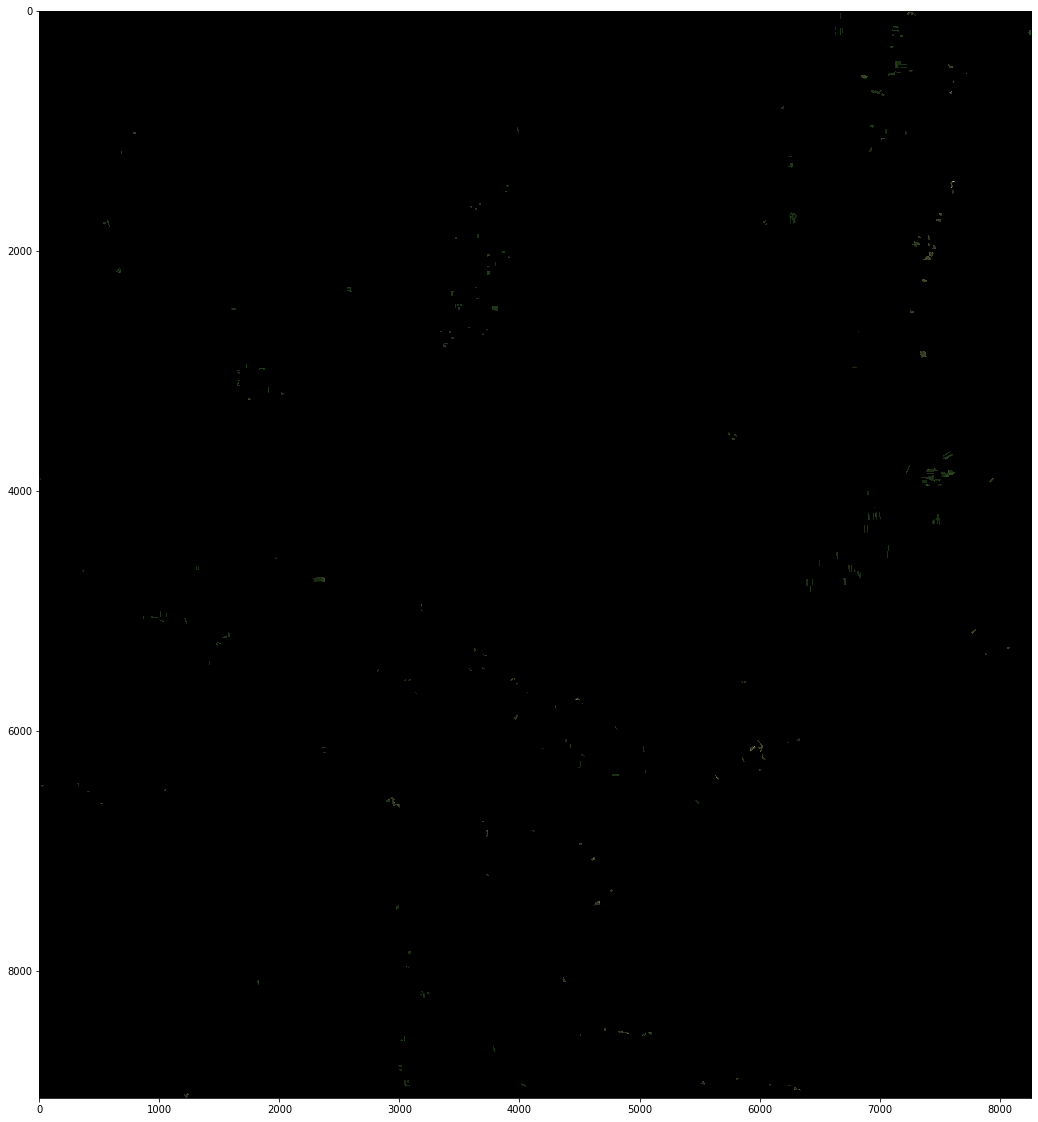

In [4]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image)

In [27]:
np.mean(image[np.where(image[:,:,0]!=0)], axis=0) / 255.

array([0.14232158, 0.20639646, 0.10019847])

In [82]:
overgrown_df = pd.DataFrame(data=overgrown_data)

In [89]:
overgrown_df = overgrown_df.sort_values(by=['date'])

In [84]:
open_df = pd.DataFrame(data=open_data)

In [90]:
open_df = open_df.sort_values(by=['date'])

In [167]:
overgrown_df['date']

0    2016-01-03
3    2016-06-21
2    2016-08-30
1    2016-10-26
7    2018-02-26
14   2018-03-13
5    2018-05-02
11   2018-06-11
9    2018-06-21
13   2018-07-31
8    2018-08-10
6    2018-08-25
4    2018-09-04
10   2018-09-19
12   2018-10-19
Name: date, dtype: datetime64[ns]

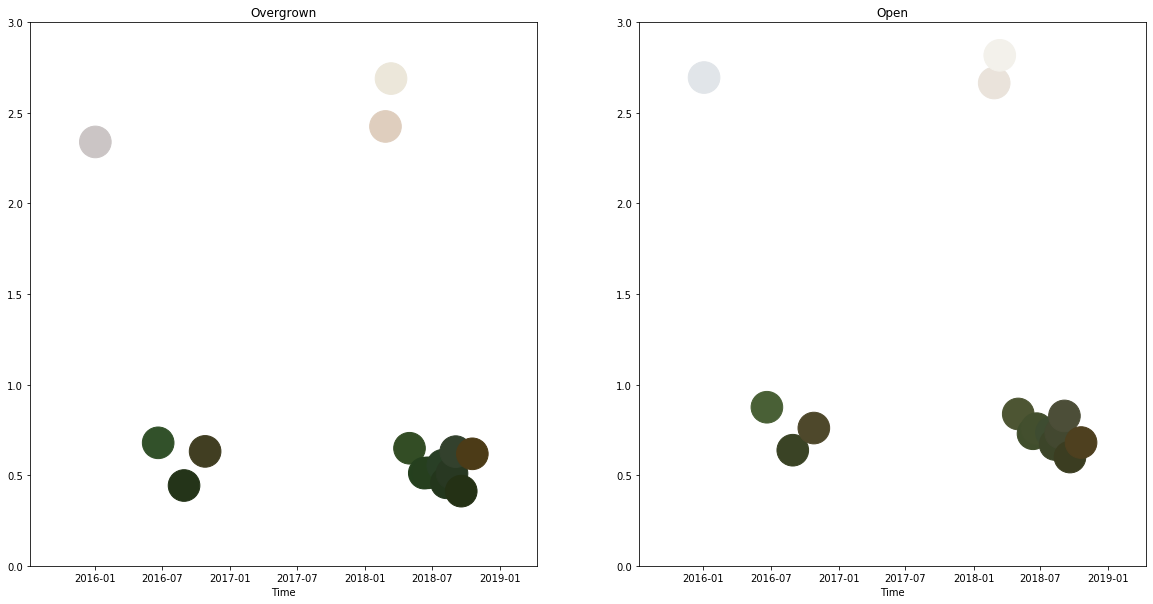

In [166]:
overgrown_y = [color.sum() for color in overgrown_df['color']]
open_y = [color.sum() for color in open_df['color']]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(x=overgrown_df['date'], 
              y=[color.sum() for color in overgrown_df['color']], 
              c=overgrown_df['color'], s=1000)
ax[1].scatter(x=open_df['date'], 
              y=[color.sum() for color in open_df['color']], 
              c=open_df['color'], s=1000)

ax[0].set_title('Overgrown')
ax[1].set_title('Open')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')

ax[0].set_ylim([0, 3])
ax[1].set_ylim([0, 3])

# plt.ylim([0, 3])
plt.show()